# Use Mauna Loa xCO2 to Estimate global xCO2

In [52]:
import os
import datetime
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
mauna = pd.read_csv('/data/artemis/observations/ESRL/Mauna_Loa_xCO2.csv',header=1)

In [4]:
mauna.head()

,year,month,mean,deseasonalized,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1958,3,315.70,314.43,NaN,NaN,NaN
1,1958,4,317.45,315.16,NaN,NaN,NaN
2,1958,5,317.51,314.71,NaN,NaN,NaN
3,1958,6,317.24,315.14,NaN,NaN,NaN
4,1958,7,315.86,315.18,NaN,NaN,NaN


In [5]:
esrl = pd.read_csv('/data/artemis/observations/ESRL/ESRL_global_xCO2.csv')
esrl.head()

,year,Month,xCO2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1980,1,338.55,NaN,NaN,NaN,NaN
1,1980,2,339.27,NaN,NaN,NaN,NaN
2,1980,3,339.60,NaN,NaN,NaN,NaN
3,1980,4,340.00,NaN,NaN,NaN,NaN
4,1980,5,340.43,NaN,NaN,NaN,NaN


In [6]:
esrl_dates = pd.date_range(start="01-01-1980",end="12-31-2020",freq='MS') + np.timedelta64(14, 'D')
ml_dates = pd.date_range(start="03-01-1958",end="8-31-2021",freq='MS') + np.timedelta64(14, 'D')

In [7]:
# Create xarrays:
esrl_xr = xr.Dataset({
                        'xco2':(["time"],esrl['xCO2'])},
                        coords={'time': (['time'],esrl_dates)})

mauna_xr = xr.Dataset({
                        'xco2':(["time"],mauna['mean'])},
                        coords={'time': (['time'],ml_dates)})

In [8]:
# Get monthly means of the differences:

diff_cycle = (mauna_xr.xco2.sel(time=slice("01-01-1980","12-31-2020")) - esrl_xr.xco2.sel(time=slice("01-01-1980","12-31-2020"))).groupby("time.month").mean("time")

Text(0.5,1,'Mauna - ESRL Mean Cycle')

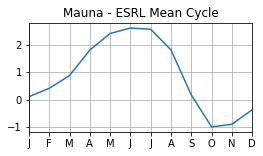

In [9]:
fig = plt.figure(figsize=(4,2))
plt.plot(diff_cycle)
plt.xticks(np.linspace(0,11,12),["J","F","M","A","M","J","J","A","S","O","N","D"])
plt.xlim(0,11)
plt.grid(True)
plt.title("Mauna - ESRL Mean Cycle")

## Use Mean Cycle of Difference to extrapolate to global xCO2 back in time

In [10]:
global_xco2 = np.empty(shape=((2020-1959+1)*12))

In [11]:
# Have years 1980 - present directly from ESRL
# Just use offset for prior to 1980

for yr in range(1959,1980):
    global_xco2[(yr-1959)*12:(yr-1958)*12] = mauna_xr.xco2.sel(time=slice(f"01-01-{yr}",f"12-31-{yr}")).values - diff_cycle.values

global_xco2[(1980-1959)*12:(2020-1958)*12] = esrl_xr.xco2.values

(715159.0, 737774.0)

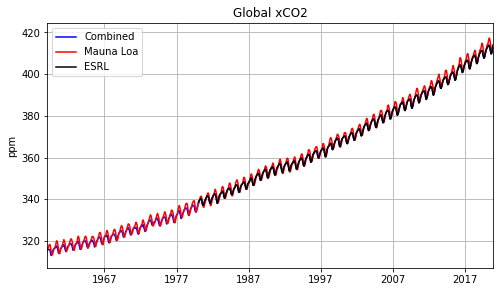

In [40]:
global_dates = pd.date_range(start="01-01-1959",end="12-31-2020",freq='MS') + np.timedelta64(14, 'D')

fig = plt.figure(figsize=(8,4.5))
plt.plot(global_dates.values,global_xco2,'blue',label='Combined')
plt.plot(mauna_xr.time,mauna_xr.xco2,color='red',label="Mauna Loa")
plt.plot(esrl_xr.time,esrl_xr.xco2,color='black',label="ESRL")
plt.grid(True)
plt.title("Global xCO2")
plt.ylabel("ppm")
plt.legend()
plt.xlim(min(global_dates.values),max(global_dates.values))

In [60]:
# Write to File
global_xco2_xr = xr.Dataset({
                        'xco2':(["time"],global_xco2),
                        'diff_cycle':(["month"],diff_cycle.values)},
                        coords={'time': (['time'],global_dates)})

global_xco2_xr['xco2'].attrs['units'] = "ppm"
global_xco2_xr['diff_cycle'].attrs['more info'] = "Mean seasonal cycle of (Mauna Loa - ESRL) for 1980-2020"
global_xco2_xr['diff_cycle'].attrs['units'] = "ppm"
global_xco2_xr.attrs['more_info'] = "Prior to 1980, Global xCO2 estimated by Mauna Loa + Mean Seasonal Cycle of difference between Mauna Loa and ESRL for 1980-2020. After 1979, ESRL is used"
global_xco2_xr.attrs['created_by'] = "Val Bennington, Mauna_ESRL.ipynb"     
global_xco2_xr.to_netcdf("/data/artemis/observations/ESRL/global_xco2_1959-2020.nc")

Text(0.5,1,'1980 xCO2')

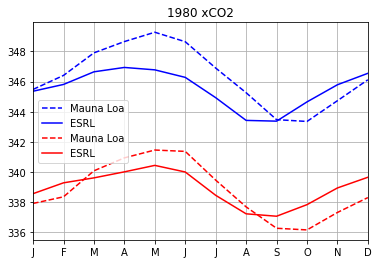

In [51]:
fig = plt.figure()
plt.plot(mauna_xr.xco2.sel(time=slice("01-01-1985","12-31-1985")).values,'b--',label="Mauna Loa")
plt.plot(esrl_xr.xco2.sel(time=slice("01-01-1985","12-31-1985")).values,'blue',label="ESRL")
plt.plot(mauna_xr.xco2.sel(time=slice("01-01-1980","12-31-1980")).values,'r--',label="Mauna Loa")
plt.plot(esrl_xr.xco2.sel(time=slice("01-01-1980","12-31-1980")).values,'red',label="ESRL")
plt.xticks(np.linspace(0,11,12),["J","F","M","A","M","J","J","A","S","O","N","D"])
plt.xlim(0,11)
plt.grid(True)
plt.legend()
plt.title("1980 xCO2")

## Create mapped pCO2 from timeseries of xCO2

In [15]:
def calc_pco2_from_xco2(xco2,pres,T,S):
    
    import math
#test:
#% xco2=378.16;
#% pres=1018.02;
#% T=15;
#% S=35;


    #calculate pressure at 100% humidity
    a1 = -7.85951783
    a2 = 1.84408259
    a4 = 22.6807411
    a5 = -15.9618719
    a3 = -11.7866497
    a6 = 1.80122502
    
    Tc = 647.096;
    pc = 22064000;
    T=T+273.15;

    Phi=(1-(T/Tc));
    lnform=(Tc/T)*(a1*Phi+a2*Phi**(1.5)+a3*Phi**3+a4*Phi**(3.5)+a5*Phi**(4)+a6*Phi**(7.5));
    Psig = 2.71828**(lnform)*pc

    molarity=(31.998*S)/(10**3-1.005*S);
    Psi=0.90799-0.08992*(0.5*molarity)+0.18458*(0.5*molarity)**2-0.07395*(0.5*molarity)**3-0.00221*(0.5*molarity)**4;
    Psigcor = Psig*2.71828**(-0.018*Psi*molarity)

    # convert pressure from hPa to Pascal
    pres=pres*100;

    # calculate pCO2 wet in Pa
    pco2_Pa= (xco2*10**-6)*(pres-Psigcor);

    # and convert into muatm
    pco2=pco2_Pa*9.8692326671601E-6*10**6;

    return pco2

In [17]:
# Grab appropriate SST, SSS, and SLP:

# NOAA ERSST:
SST = xr.open_dataset("/data/artemis/observations/NOAA_ERSST/NOAA_ERSST_1x1_mon_Jan1854-Feb2020.nc")
sst = SST.sst.sel(time=slice("01-01-1959","12-31-2019"))

# EN4.2.1 Salinity:
SSS = xr.open_dataset(f"/data/artemis/workspace/vbennington/EN421_salinity/processed/sss_1x1_mon_EN421_195801-202011.nc").sss
sss = SSS.sel(time=slice("01-01-1959","12-31-2019"))

# SLP from ERA5:
era5 = xr.open_dataset('/data/artemis/observations/ERA5/processed/ERA5_MSLP_WS10_1x1_mon_1958-2020.nc')
era5 = era5.sel(time=slice("01-01-1959","12-31-2019"))
era5 = era5.rename({"ylat":"lat","xlon":"lon"})
slp = era5.mslp / 100 # Pascals to hPa


In [18]:
xco2 = xr.open_dataset("/data/artemis/observations/ESRL/global_xco2_1959-2020.nc").xco2.sel(time=slice("01-01-1959","12-31-2019"))
sst['time'] = xco2['time']
sss['time'] = xco2['time']
slp['time'] = xco2['time']

In [19]:
pco2 = calc_pco2_from_xco2(xco2,slp,sst,sss)

In [41]:
mauna_pco2 = calc_pco2_from_xco2(mauna_xr.xco2.sel(time=slice("01-01-1959","12-31-2019")),slp,sst,sss)

Text(0.5,1,'Water Vapor Corrected pCO2')

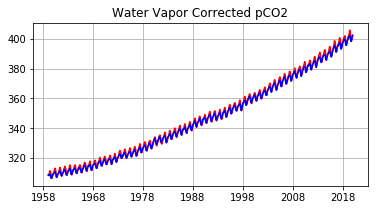

In [43]:
fig = plt.figure(figsize=(6,3))
plt.plot(xco2.time,mauna_pco2.mean(['lat','lon']),'red')
plt.plot(xco2.time,pco2.mean(['lat','lon']),'blue')
plt.grid(True)
plt.title("Water Vapor Corrected pCO2")

Text(0.5,1,'Water Vapor Corrected pCO2')

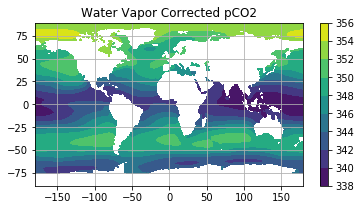

In [108]:
fig = plt.figure(figsize=(6,3))
plt.contourf(sst.lon,sst.lat,pco2.mean('time'))
plt.colorbar()
plt.grid(True)
plt.title("Water Vapor Corrected pCO2")

In [46]:
# Write to File
global_pco2_xr = xr.Dataset({
                        'pco2':(["time","lat","lon"],pco2),
                        'mauna_loa_pco2':(["time","lat","lon"],mauna_pco2)},
                        coords={'time': (['time'],xco2.time.values),
                               'lat':(['lat'],sst.lat.values),
                               'lon':(['lon'],sst.lon.values)})

global_pco2_xr['pco2'].attrs['units'] = "micro atm"
global_pco2_xr['pco2'].attrs['more info'] = "Water Vapor Corrected pCO2 using joined Mauna Loa (prior to 1980) and ESRL"
global_pco2_xr['mauna_loa_pco2'].attrs['units'] = "micro atm"
global_pco2_xr['mauna_loa_pco2'].attrs['more info'] = "Water Vapor Corrected pCO2 using joined Mauna Loa entire time"
global_pco2_xr.attrs['more_info'] = "Prior to 1980, Global xCO2 estimated by Mauna Loa + Mean Seasonal Cycle of difference between Mauna Loa and ESRL for 1980-2019. After 1979, ESRL is used"
global_pco2_xr.attrs['description'] = "NOAA ERSST, EN4.2.1 SSS, ERA5 SLP used to get water vapor correction"
global_pco2_xr.attrs['created_by'] = "Val Bennington, Mauna_ESRL.ipynb"     
global_pco2_xr.to_netcdf("/data/artemis/observations/ESRL/global_pco2_1959-2019.nc")